In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import time

# Preparing the datasets

In [3]:
def load_mnist_data(batch_size=64):
    """
    Function that loads the MNIST data set. Returns the Train and Test dataset DataLoaders.
    Altought for the testing we use an exeternal test set. The MNIST provided test set will be
    used as a validation set after every epoch when training. The accuracy values will be compared
    later with the accuracy on the test set.
    """
    transform = transforms.Compose([
        transforms.ToTensor(), # converts images to PyTorch tensros
        transforms.Normalize((0.5,), (0.5,)) # Normalizes the images, with a mean and std of 0.5
    ])
    
    # load the training and validation datasets. 
    # set download=True if the the MNIST dataset is not already in the working directory
    # else if the MNIST is already downloaded, set download=False
    # The dataset is gotten from the torchvision package
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False) # used as validation set during training

    # create the DataLoaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle the training set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Don't shuffle the validation set
    
    return train_loader, test_loader


In [4]:
def load_custom_test_data(X_path, y_path, batch_size=64):
    """
    Function that the external test set. Returns the test set DataLoader.
    After the training of a model is complete, it will be tested on this dataset.
    """

    # Loads the external test data from the provided paths './digits_X.npy', './digits_Y.npy' (files should be in the working directory)
    X_test = np.load(X_path) # images represented in an numpy array (.npy) with numbers for each pixel value
    y_test = np.load(y_path) # labels also stored in numpy array (.npy) with numbers from 0-9 for each digit
    
    # Convert the images to PyTorch sensors
    # Additioanlly, normalize them by dividing by 255 (greyscale range is 0-255)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32) / 255
    
    # Convert labels to PyTorch tensors with 'long' type which is neccesasry for classifcation tasks
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    class CustomDataset(Dataset):
        "Class that creates the dataset from the external test data"
        def __init__(self, X, y, transform=None):
            self.X = X # store the test images
            self.y = y # store the test labels
            self.transform = transform # transformation applied to the images

        def __len__(self):
            # return the total number of images in the dataset
            return len(self.X)

        def __getitem__(self, idx):
            # fetch the image and label for given index
            image = self.X[idx]
            label = self.y[idx]
            
            if self.transform:
                image = self.transform(image) # apply transformation (normalization)
                
            return image, label
    
    # define transformation for the test images
    transform_test = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,)) # Normalizes the images, with a mean and std of 0.5
    ])
    
    # Create the actual dataset from the loaded test data
    test_dataset = CustomDataset(
        X_test_tensor.unsqueeze(1), # add a channel dimension for greyscale images
        y_test_tensor, transform=transform_test
    ) 

    # Create a DataLoader for the test dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # no shuffling neccessary
    
    return test_loader


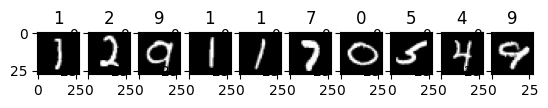

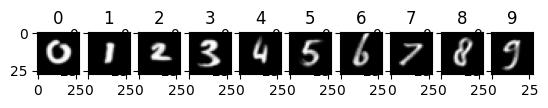

In [5]:
"Visualize both sets to verify they are loaded correctly"
train_loader, _ = load_mnist_data(batch_size=64) # load the MNIST trainig set, discard validation loader
test_loader = load_custom_test_data('./digits_X.npy', './digits_Y.npy', batch_size=64) # load the test dataset

# get a batch from the training set
examples_train = iter(train_loader)
images_train, labels_train = next(examples_train)

# get a batch from the test set
examples_test = iter(test_loader)
images_test, labels_test = next(examples_test)

# visualize first 10 samples of training set
for i in range(10):
    plt.subplot(1, 10, i + 1) # 1 row, 10 columns
    plt.imshow(images_train[i][0], cmap='gray') # display the images in greyscale
    plt.title(f'{labels_train[i].item()}')
plt.show()

# visualize first 10 samples of test set 
for i in range(10):
    plt.subplot(1, 10, i + 1) # 1 row, 10 columns
    plt.imshow(images_test[i][0], cmap='gray') # display the images in greyscale
    plt.title(f'{labels_test[i].item()}')
plt.show()



# Defining the neural network architectures

In [6]:

"Here is defined a Fully connected NN with a single hidden layer"
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        
        """
        Parameters: 
        input_size: 28x28=784 for MNIST images
        hidden_size: number of neurons in the hidden layer
        num_classes: number of output classes (digits 0-9)
        """
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #  define 1st FC layer (input to hidden)
        self.relu = nn.ReLU() # define ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # define 2nd FC layer (hidden to output)
    
    def forward(self, x):
        # X: the input tensor (shape is (batch_size, input_size))
        x = x.view(x.size(0), -1)  # flatten  the input
        x = self.fc1(x) # apply first FC
        x = self.relu(x) # apply ReLU
        x = self.fc2(x) # apply second FC
        # now X a tensor is of shape (batch_size, num_classes)
        
        return x


In [7]:
"Here is defined a Fully connected NN with three hidden layers"
class FullyConnectedNN3Layers(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64, 32], num_classes=10):
        """
        Parameters: 
        input_size: 28x28=784 for MNIST images
        hidden_size: list containing the number of neurons in each hidden layer
        num_classes: number of output classes (digits 0-9)
        """
        super(FullyConnectedNN3Layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0]) #  define 1st FC layer (input to first hidden)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1]) #  define 2st FC layer (first hidden to second hidden)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2]) #  define 3st FC layer (second hidden to third hidden)
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes) #  define output FC layer (third hidden to output)
        self.relu = nn.ReLU() # define ReLU activation function
    
    def forward(self, x):
        # X: the input tensor (shape is (batch_size, input_size))
        x = x.view(x.size(0), -1) # flatten the input
        x = self.fc1(x) # apply 1st FC
        x = self.relu(x) # ReLU activation after every layer
        x = self.fc2(x) # apply 2nd FC
        x = self.relu(x)
        x = self.fc3(x)# apply 3st FC
        x = self.relu(x)
        x = self.fc4(x) # apply final FC
        # now X a tensor is of shape (batch_size, num_classes)
        
        return x

In [8]:
"Here is defined a simple CNN with a single convolution layer"
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Parameters: 
        num_classes: number of output classes (digits 0-9)
        """
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # define the convolutin layer
        # input channels = 1 (greyscale images), output channels = 16
        # kernel size = 3x3, stride = 1 (no downsampling), padding = 1 (preserve image size)
        self.fc1 = nn.Linear(16 * 28 * 28, num_classes) # define the FC layer
        # input features = 16 feature maps of size 28*28

    def forward(self, x):
        # X: the input tensor (shape is (batch_size, 1, 28, 28))
        x = F.relu(self.conv1(x)) # apply convolutional layer with ReLU activation
        x = x.view(x.size(0), -1) # flatten the features into a single vector
        x = self.fc1(x) # apply the FC to get classification
        # now X a tensor is of shape (batch_size, num_classes)
        
        return x 
    

In [9]:
class CNNThreeLayers(nn.Module):
    def __init__(self, num_classes=10):
        """
        Parameters:
        num_classes: Number of output classes (digits 0-9).
        """
        super(CNNThreeLayers, self).__init__()
        # 1st convolutional layer: input channels = 1 (grayscale), output channels = 16
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # 2nd convolutional layer: input channels = 16, output channels = 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # 3rd convolutional layer: input channels = 32, output channels = 64
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # FC: input features =64 feature maps of size 28x28, output = num_classes
        self.fc1 = nn.Linear(64 * 28 * 28, num_classes)

    def forward(self, x):
        # X: the input tensor (shape is (batch_size, 1, 28, 28))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten the features into a single vector
        x = self.fc1(x)
        # now X a tensor is of shape (batch_size, num_classes)

        return x

# Defining model training and evaluation functions

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    """
    A function that trains a model for a number of epochs. Returns the train loss, validation loss,
    and validation accuracy values that are stored in a list. Those are later used for visualization.

    Parameters:
    model: The model to be trained.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function to be optimized.
    optimizer: Optimization algorithm.
    num_epochs: Number of training epochs.
    """

    # Lists to store metrics across epochs
    train_losses = []
    val_losses = []
    val_accuracies = []  
    
    model.train() # Set mode lto training mode
    for epoch in range(num_epochs):
        running_loss = 0.0 # accumulate training loss for the epoch
        for images, labels in train_loader: # loop through the images in a batch
            images, labels = images.to(device), labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) # calculate the loss
            
            # backward pass
            optimizer.zero_grad() # clear previous gradients
            loss.backward() # compute gradients
            optimizer.step() # update model parameters
            
            running_loss += loss.item() # accumulate the batch loss

        # calculate and store average training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # evaluate the model on the validation set and store metrics
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies


def evaluate_model(model, test_loader, criterion=None):
    """
    A function that evaluates a model. Returns the average loss and accuracy for the validation set.
    For the test set it will return the accuracy (avg_loss will be None)
    
    Parameters:
    model: The  model to be evaluated.
    test_loader: DataLoader for the test or validation dataset.
    criterion: Loss function, optional (used for calculating loss).
    
    """

    model.eval() # Set model to evaluation mode
    correct = 0 # count of correct classifications
    total = 0 # total samples
    running_loss = 0.0  # accumulate loss during evaluation
    
    with torch.no_grad(): # disable gradiant computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # forward pass
            _, predicted = torch.max(outputs.data, 1) # get predicted class by taking index of the max value
            total += labels.size(0) # update total sample count
            correct += (predicted == labels).sum().item() # update correct counts
            
            # if criterion is provided, calculate the loss
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
    
    accuracy = 100 * correct / total # calculate the accuracy as a precentage
    avg_loss = running_loss / len(test_loader) if criterion else None
    
    return avg_loss, accuracy



In [11]:
# here we check if a GPU is available to run the trainig, 
# training on GPU can speed up computations
# however, it is not necessary for this task
# each model shouldn't take more than 1-2 minutes on a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64 # define batch size for DataLoaders
train_loader, validation_loader = load_mnist_data(batch_size) # load the training and validations DataLoaders for the MNIST dataset
test_loader = load_custom_test_data('./digits_X.npy', './digits_Y.npy', batch_size) # load the external dataset
# An external dataset helps us evaluate the models generalization capability

# define the loss function for the models
# CrossEntropyLoss is well suited for multi-class classification tasks, it combines softmax and negative log-likelihood loss
criterion = nn.CrossEntropyLoss()


In [12]:
def train_test_fc_one_layer(train_loader, validation_loader, test_loader, criterion, num_epochs=5):
    """
    Function that trains and tests the simple fully connected network with one hidden layer.
    Returns the lists of training loss, validation loss and accuracries for every epoch. Also returns
    the final accuracy on the test set once the model is trained.

    Parameters:
    train_loader: DataLoader for the training dataset.
    validation_loader: DataLoader for the validation dataset.
    test_loader: DataLoader for the external test dataset.
    criterion: Loss function used for optimization.
    num_epochs: Number of epochs for training.
    """

    # initialize the FC network 
    model = FullyConnectedNN(input_size=784, hidden_size=128, num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # define the optimizer

    start_time = time.time()

    train_losses, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs) # train the model
    _, test_accuracy = evaluate_model(model, test_loader, criterion) # get accuracy on the external test set

    end_time = time.time()
    duration = end_time - start_time
    
    return train_losses, val_losses, val_accuracies, test_accuracy, duration


In [13]:
def train_test_fc_three_layers(train_loader, validation_loader, test_loader, criterion, num_epochs=5):
    """
    Function that trains and tests the fully connected network with three hidden layers.
    Returns the lists of training loss, validation loss and accuracries for every epoch. Also returns
    the final accuracy on the test set once the model is trained.

    Parameters:
    train_loader: DataLoader for the training dataset.
    validation_loader: DataLoader for the validation dataset.
    test_loader: DataLoader for the external test dataset.
    criterion: Loss function used for optimization.
    num_epochs: Number of epochs for training.
    """

    # initialize the FC network 
    model = FullyConnectedNN3Layers(input_size=784, hidden_sizes=[128, 64, 32], num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # define the optimizer

    start_time = time.time()

    train_losses, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs) # train the model
    _, test_accuracy = evaluate_model(model, test_loader, criterion) # get accuracy on the external test set
    
    end_time = time.time()
    duration = end_time - start_time

    return train_losses, val_losses, val_accuracies, test_accuracy, duration

In [14]:
def train_test_cnn_one_layer(train_loader, validation_loader, test_loader, criterion, num_epochs=5):
    """
    Function that trains and tests the simple CNN with one convolution layer.
    Returns the lists of training loss, validation loss and accuracries for every epoch. Also returns
    the final accuracy on the test set once the model is trained.

    Parameters:
    train_loader: DataLoader for the training dataset.
    validation_loader: DataLoader for the validation dataset.
    test_loader: DataLoader for the external test dataset.
    criterion: Loss function used for optimization.
    num_epochs: Number of epochs for training.
    """

    # initialize the CNN 
    model = SimpleCNN(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # define the optimizer

    start_time = time.time()

    train_losses, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs) # train the model
    _, test_accuracy = evaluate_model(model, test_loader, criterion) # get accuracy on the external test set

    end_time = time.time()
    duration = end_time - start_time

    return train_losses, val_losses, val_accuracies, test_accuracy, duration


In [15]:
def train_test_cnn_three_layer(train_loader, validation_loader, test_loader, criterion, num_epochs=5):
    """
    Function that trains and tests the simple CNN with one convolution layer.
    Returns the lists of training loss, validation loss and accuracries for every epoch. Also returns
    the final accuracy on the test set once the model is trained.

    Parameters:
    train_loader: DataLoader for the training dataset.
    validation_loader: DataLoader for the validation dataset.
    test_loader: DataLoader for the external test dataset.
    criterion: Loss function used for optimization.
    num_epochs: Number of epochs for training.
    """

    # initialize the CNN 
    model = CNNThreeLayers(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # define the optimizer

    start_time = time.time()

    train_losses, val_losses, val_accuracies = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs) # train the model
    _, test_accuracy = evaluate_model(model, test_loader, criterion) # get accuracy on the external test set

    end_time = time.time()
    duration = end_time - start_time

    return train_losses, val_losses, val_accuracies, test_accuracy, duration

# Plotting functions

In [16]:
def plot_validation_metrics(val_losses_1, val_accuracies_1, val_losses_2, val_accuracies_2, val_losses_3, val_accuracies_3, val_losses_4, val_accuracies_4):
    """
    Function that plots the two metrics for each model:
    1st plot is visualzing the line of validation loss over epochs
    2nd plot is visualizing the line of validation accuracy over epochs
    """
    epochs = range(1, len(val_losses_1) + 1)

    # Validation loss plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_losses_1, label="FC 1-Layer Val Loss")
    plt.plot(epochs, val_losses_2, label="FC 3-Layer Val Loss")
    plt.plot(epochs, val_losses_3, label="CNN 1-Layer Val Loss")
    plt.plot(epochs, val_losses_4, label="CNN 3-Layer Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Validation accuracy plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies_1, label="FC 1-Layer Val Accuracy")
    plt.plot(epochs, val_accuracies_2, label="FC 3-Layer Val Accuracy")
    plt.plot(epochs, val_accuracies_3, label="CNN 1-Layer Val Accuracy")
    plt.plot(epochs, val_accuracies_3, label="CNN 1-Layer Val Accuracy")
    plt.plot(epochs, val_accuracies_4, label="CNN 3-Layer Val Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()


In [17]:
def plot_test_vs_validation(test_scores, val_accuracies):
    """
    Function that plots the final validation accuracy vs the accuracy on the test set
    for each model. 
    """
    labels = ['FC 1-Layer', 'FC 3-Layer', 'CNN 1-Layer', 'CNN 3-Layer']
    x = range(len(labels))
    
    plt.figure(figsize=(8, 5))
    plt.bar(x, test_scores, width=0.4, label='Test Accuracy', align='center')
    plt.bar(x, val_accuracies, width=0.2, label='Final Val Accuracy', align='edge')
    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy vs Final Validation Accuracy')
    plt.xticks(x, labels)
    plt.legend(loc="lower left")
    plt.show()


In [18]:
def plot_run_time(running_times):
    """
    Function that plots the training time for each model
    """

    labels = ['FC 1-Layer', 'FC 3-Layer', 'CNN 1-Layer', 'CNN 3-Layer']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, running_times, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Running Time (seconds)')
    plt.title('Running Time for Each Model')
    plt.show()

# Getting the results. Calling the functions

In [19]:
train_losses_1, val_losses_1, val_accuracies_1, test_score_1, duration_1 = train_test_fc_one_layer(train_loader, validation_loader, 
                                                                                       test_loader, criterion, num_epochs=5)
train_losses_2, val_losses_2, val_accuracies_2, test_score_2, duration_2 = train_test_fc_three_layers(train_loader, validation_loader,
                                                                                           test_loader, criterion, num_epochs=5)
train_losses_3, val_losses_3, val_accuracies_3, test_score_3, duration_3 = train_test_cnn_one_layer(train_loader, validation_loader,
                                                                                         test_loader, criterion, num_epochs=5)
train_losses_4, val_losses_4, val_accuracies_4, test_score_4, duration_4 = train_test_cnn_three_layer(train_loader, validation_loader,
                                                                                         test_loader, criterion, num_epochs=5)

Epoch [1/5] - Train Loss: 0.3794, Val Loss: 0.2245, Val Accuracy: 93.21%
Epoch [2/5] - Train Loss: 0.1892, Val Loss: 0.1533, Val Accuracy: 95.25%
Epoch [3/5] - Train Loss: 0.1369, Val Loss: 0.1165, Val Accuracy: 96.54%
Epoch [4/5] - Train Loss: 0.1092, Val Loss: 0.1061, Val Accuracy: 96.70%
Epoch [5/5] - Train Loss: 0.0930, Val Loss: 0.1024, Val Accuracy: 96.82%
Epoch [1/5] - Train Loss: 0.4486, Val Loss: 0.2623, Val Accuracy: 92.07%
Epoch [2/5] - Train Loss: 0.2085, Val Loss: 0.1580, Val Accuracy: 95.03%
Epoch [3/5] - Train Loss: 0.1523, Val Loss: 0.1422, Val Accuracy: 95.37%
Epoch [4/5] - Train Loss: 0.1264, Val Loss: 0.1602, Val Accuracy: 95.10%
Epoch [5/5] - Train Loss: 0.1070, Val Loss: 0.1233, Val Accuracy: 96.35%
Epoch [1/5] - Train Loss: 0.2570, Val Loss: 0.1110, Val Accuracy: 96.73%
Epoch [2/5] - Train Loss: 0.0931, Val Loss: 0.0971, Val Accuracy: 97.13%
Epoch [3/5] - Train Loss: 0.0638, Val Loss: 0.0815, Val Accuracy: 97.53%
Epoch [4/5] - Train Loss: 0.0481, Val Loss: 0.0689,

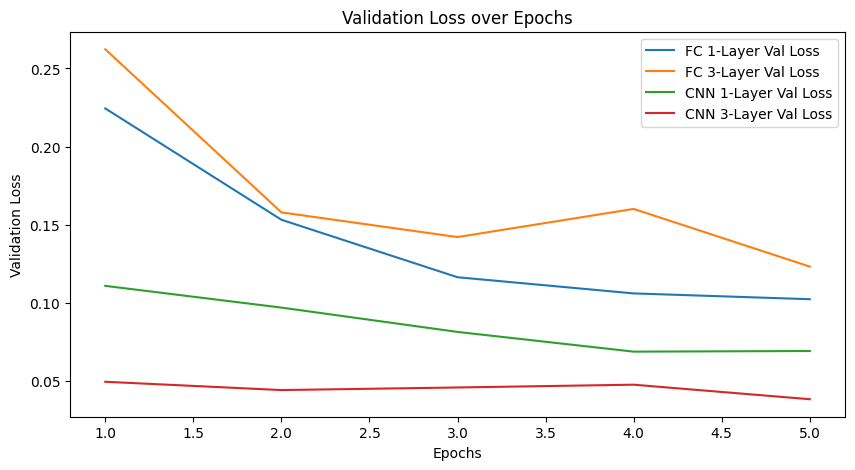

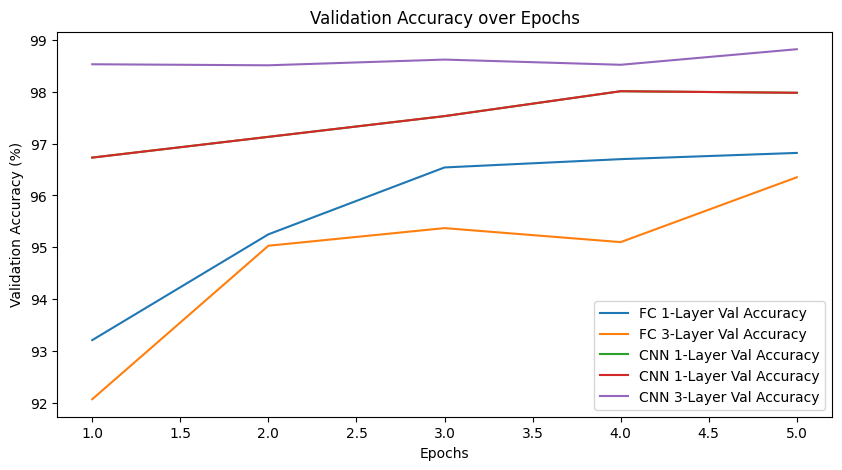

In [20]:
plot_validation_metrics(val_losses_1, val_accuracies_1, val_losses_2, val_accuracies_2, val_losses_3, val_accuracies_3, val_losses_4, val_accuracies_4)

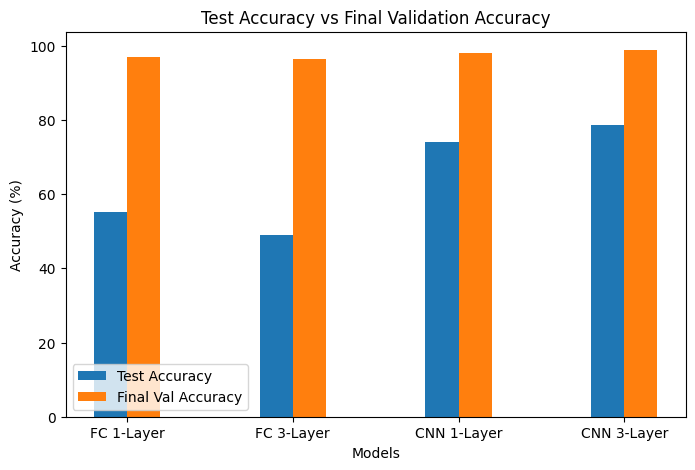

In [21]:
test_scores = [test_score_1, test_score_2, test_score_3, test_score_4]
final_val_accuracies = [val_accuracies_1[-1], val_accuracies_2[-1], val_accuracies_3[-1], val_accuracies_4[-1]]
plot_test_vs_validation(test_scores, final_val_accuracies)

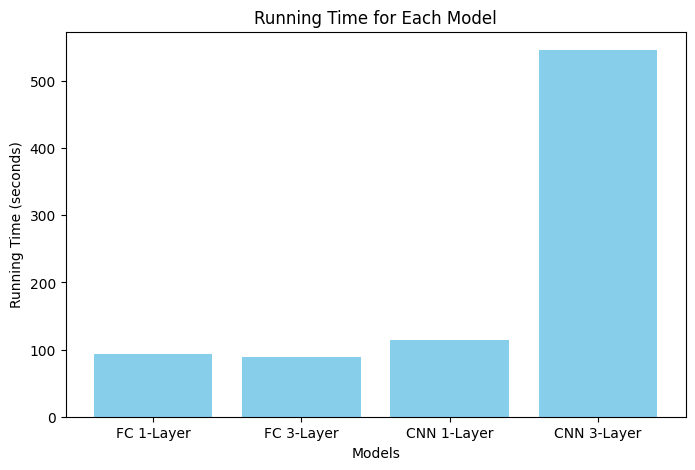

In [22]:
running_times = [duration_1, duration_2, duration_3, duration_4]
plot_run_time(running_times)
